In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import os
import torchvision
import glob
import math
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets ,transforms 
from torch.utils.data import DataLoader ,random_split
from torchvision.io import read_image
import torch.nn.functional as F

torch.manual_seed(2021)
# Device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# read data sets without change png or jpg and without structure the data
data_dir = 'Train'
images_list = os.listdir(data_dir)
df =pd.DataFrame({'dirs':images_list})
df['label'] = df['dirs'].str.replace('_\d+.\w{3}',"",regex= True)

#data set class
class sport_dataset(datasets.DatasetFolder):  
  def __init__(self, root,df ,transform=None, target_transform=None):
    self.class_to_idx= { 
          'Basketball': 0, 'Football':1,
          'Rowing':2,'Swimming':3,
          'Tennis':4,'Yoga':5}
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    df['label'] = df['label'].map(self.class_to_idx)
    
    self.dir = root if root[-1] == '/' else root+'/'
    self.image_labels = df['label'].tolist()
    self.images = df['dirs'].tolist()
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.image_labels)

  def __getitem__(self, idx):
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    label = self.image_labels[idx]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

class sport_dataset_test(datasets.DatasetFolder): 
  def __init__(self, root ,transform=None, target_transform=None):
    self.dir = root if root[-1] == '/' else root+'/'
    df= pd.DataFrame({'dirs':os.listdir(root)})
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    self.images = df["dirs"].to_list()
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
        
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    if self.transform:
        image = self.transform(image)
    return image, self.images[idx]

In [6]:
num_classes = 6
num_epochs = 50
BATCH_SIZE = 16


In [7]:
data_dir = 'Train'
test_dir = 'Test/'
split_size = 0.2
train_df, val_df = train_test_split(df, test_size=split_size, shuffle=True,stratify=df[['label']])


In [8]:
vc = train_df.label.value_counts()
vct=vc.max() - vc
for clas , value in vct.to_dict().items():
    smaple_df = train_df.loc[train_df['label']==clas ,:]
    if value > 0:
        train_df = train_df.append(smaple_df.sample(value,replace= True,random_state =49), ignore_index=True)
train_df['label'].value_counts()

Tennis        366
Swimming      366
Basketball    366
Yoga          366
Rowing        366
Football      366
Name: label, dtype: int64

In [9]:
tranform_train = transforms.Compose([#transforms.RandomVerticalFlip(p=0.2) ,
                                     #transforms.RandomHorizontalFlip(p=0.2), 
                                     #transforms.RandomPerspective(distortion_scale=0.3,p=0.2),
                                     #transforms.RandomRotation(degrees=45,),
                                     transforms.Resize((240,240)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

tranform_test = transforms.Compose([transforms.Resize((240,240)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, train_df  ,transform=tranform_train)
val = sport_dataset(data_dir, val_df ,transform=tranform_test)
test = sport_dataset_test(test_dir, transform=tranform_test)

# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True)
valid_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=1,  shuffle=False ,num_workers=0)
# print train test val sizes
print(train.class_to_idx)
print(f'''
Train data size : {len(train)}  
Val data size   : {len(val)} 
Test data size  : {len(test)}
''')

{'Basketball': 0, 'Football': 1, 'Rowing': 2, 'Swimming': 3, 'Tennis': 4, 'Yoga': 5}

Train data size : 2196  
Val data size   : 337 
Test data size  : 688



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([16, 3, 240, 240])


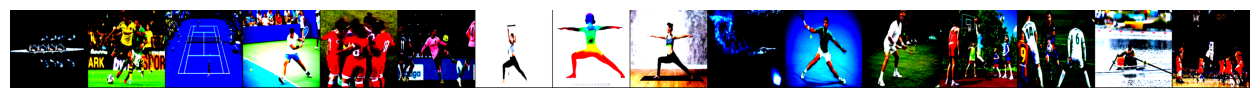

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Residual Block

In [86]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True))
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True))

def make_divisible(x, divisible_by=8):
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=6, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        #self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x



# Setting Hyperparameters

In [64]:
model = MobileNetV2(width_mult=1,n_class=1000).to(device)
st = torch.load('mobilenet_v2.pth.tar')
st.pop('classifier.1.weight')
st.pop( 'classifier.1.bias')
model.classifier = nn.Identity().to(device)
model.load_state_dict(st)
model.classifier = nn.Linear(1280, num_classes).to(device)
model.to(device)
print('state_dict loaded')

state_dict loaded


In [65]:
learning_rate = 5e-4
# Loss and optimizer
weights =  torch.tensor([1,1.15,1.15,1.1,1.5,1]).to(device).float()
criterion = nn.CrossEntropyLoss( )
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate, weight_decay = 0.0001, betas=(0.98,0.999))  
# Train the model
total_step = len(train_loader)

# Training:

In [67]:
def feed_and_back(images , labels , back_prop = True):
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    # Backward and optimize
    if back_prop:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect()
    return  loss , predicted , correct

In [68]:
import gc
train_losses = []
val_losses = []
train_acc = []
val_acc = []
acc_old = 0 
num_epochs = 15
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = True)
        correct += correct_batch
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)     
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in valid_loader:
            loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = False)
            correct += correct_batch
        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
            acc_old = val_acc[-1]
            torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), (100 * correct) / len(val)))
        



Epoch [1/15]: 
              T_Loss: 0.5337 , T_ACC: 77.7778% , validation:  Val_Loss: 1.4758 , Val_ACC: 88.7240%

Epoch [2/15]: 
              T_Loss: 0.1787 , T_ACC: 90.2095% , validation:  Val_Loss: 0.4780 , Val_ACC: 90.8012%

Epoch [3/15]: 
              T_Loss: 0.2503 , T_ACC: 92.1676% , validation:  Val_Loss: 0.4914 , Val_ACC: 92.2849%

Epoch [4/15]: 
              T_Loss: 0.0901 , T_ACC: 94.0346% , validation:  Val_Loss: 0.4152 , Val_ACC: 92.2849%

Epoch [5/15]: 
              T_Loss: 0.1735 , T_ACC: 93.9435% , validation:  Val_Loss: 0.1995 , Val_ACC: 93.4718%

Epoch [6/15]: 
              T_Loss: 0.0783 , T_ACC: 94.3534% , validation:  Val_Loss: 0.1539 , Val_ACC: 95.5490%

Epoch [7/15]: 
              T_Loss: 0.1156 , T_ACC: 96.0383% , validation:  Val_Loss: 0.2990 , Val_ACC: 94.6588%

Epoch [8/15]: 
              T_Loss: 0.0854 , T_ACC: 95.8106% , validation:  Val_Loss: 0.1177 , Val_ACC: 95.5490%

Epoch [9/15]: 
              T_Loss: 0.0805 , T_ACC: 96.7668% , validation:  Va

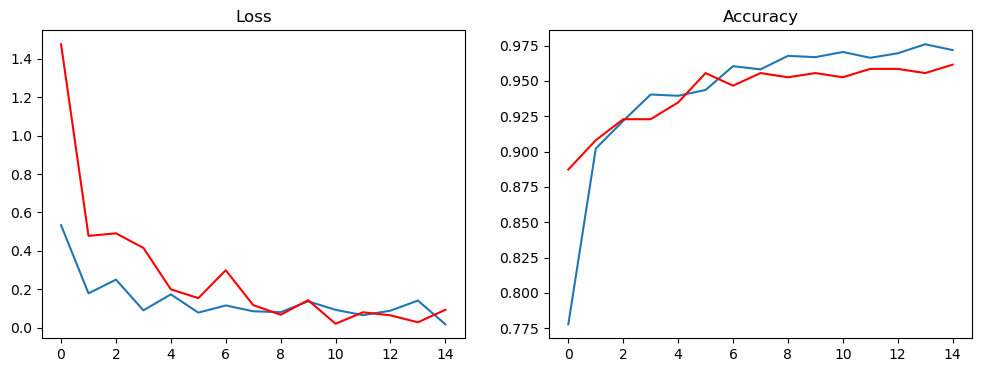

In [69]:
fig2, ax = plt.subplots(1,2,  figsize=(12,4))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[0].plot(val_losses,'-r')
ax[1].plot(val_acc,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()
torch.save(model.state_dict(), 'best_model_last.pt')

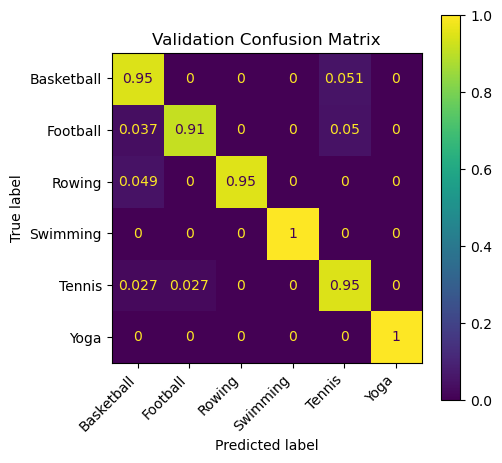

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

In [ ]:
#model.load_state_dict(torch.load('best_model_xc.pt'))
#model.eval()

In [74]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

maxmium valadtion accuarcy : 0.9614% at Epoch 15 


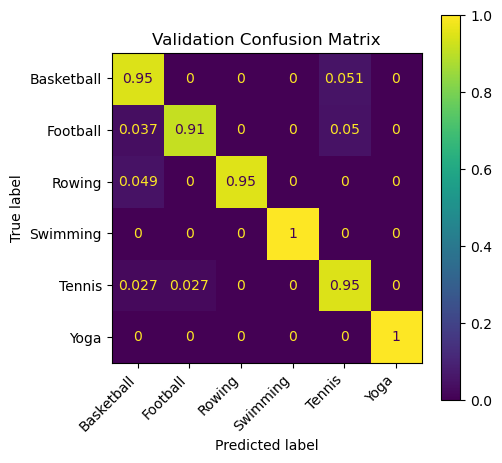

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

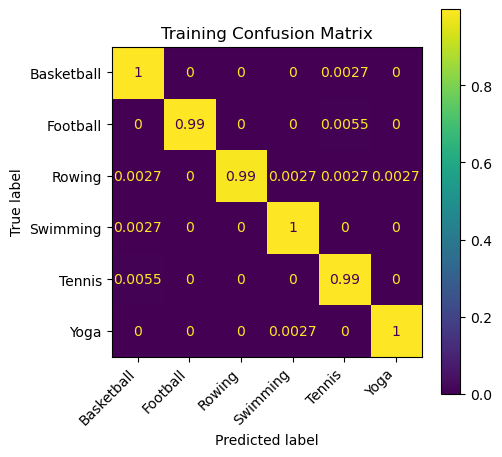

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Training Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

In [77]:
learning_rate = 9e-5
num_epochs = 20
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.2) ,
                                     transforms.RandomHorizontalFlip(p=0.4), 
                                     transforms.RandomPerspective(distortion_scale=0.5,p=0.5),
                                     transforms.RandomRotation(degrees=(-70, 70)),
                                     transforms.Resize((260,260)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

tranform_test = transforms.Compose([transforms.Resize((260,260)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, train_df  ,transform=tranform_train)
# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True)

weights =  torch.tensor([1.1,1.2,1.2,1.1,1.3,1]).to(device).float()
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.97,0.999))  

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = True)
        correct += correct_batch
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)     
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in valid_loader:
            loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = False)
            correct += correct_batch
        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
            acc_old = val_acc[-1]
            torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), (100 * correct) / len(val)))
        


Epoch [1/20]: 
              T_Loss: 0.3402 , T_ACC: 86.7486% , validation:  Val_Loss: 0.2859 , Val_ACC: 95.5490%

Epoch [2/20]: 
              T_Loss: 0.6881 , T_ACC: 94.0801% , validation:  Val_Loss: 0.3040 , Val_ACC: 93.7685%

Epoch [3/20]: 
              T_Loss: 0.2893 , T_ACC: 94.9454% , validation:  Val_Loss: 0.3021 , Val_ACC: 94.9555%

Epoch [4/20]: 
              T_Loss: 0.3026 , T_ACC: 96.9035% , validation:  Val_Loss: 0.3034 , Val_ACC: 96.4392%

Epoch [5/20]: 
              T_Loss: 0.4432 , T_ACC: 97.3588% , validation:  Val_Loss: 0.3106 , Val_ACC: 98.5163%

Epoch [6/20]: 
              T_Loss: 0.2929 , T_ACC: 98.1785% , validation:  Val_Loss: 0.3205 , Val_ACC: 96.4392%

Epoch [7/20]: 
              T_Loss: 0.3837 , T_ACC: 97.9508% , validation:  Val_Loss: 0.3111 , Val_ACC: 97.0326%

Epoch [8/20]: 
              T_Loss: 0.3746 , T_ACC: 97.8597% , validation:  Val_Loss: 0.3249 , Val_ACC: 95.5490%

Epoch [9/20]: 
              T_Loss: 0.3134 , T_ACC: 98.5428% , validation:  Va

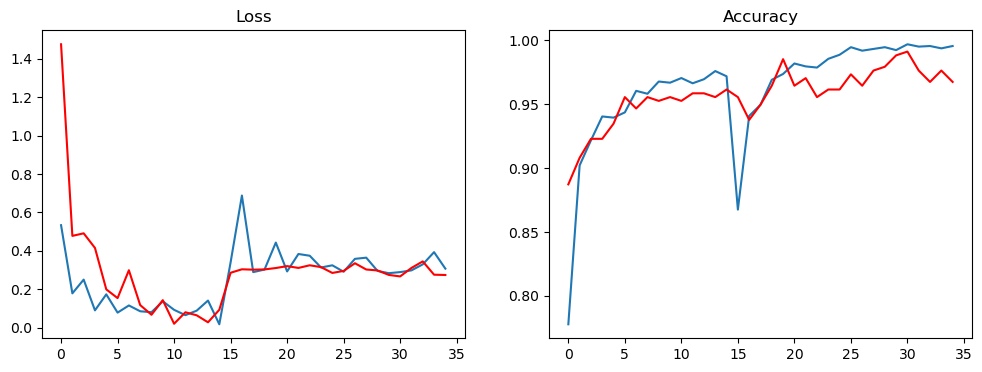

In [80]:
fig2, ax = plt.subplots(1,2,  figsize=(12,4))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[0].plot(val_losses,'-r')
ax[1].plot(val_acc,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

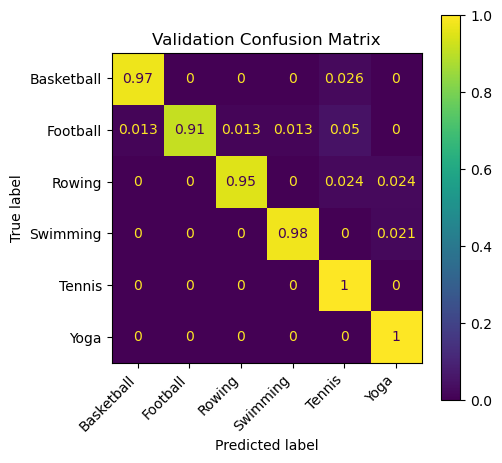

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

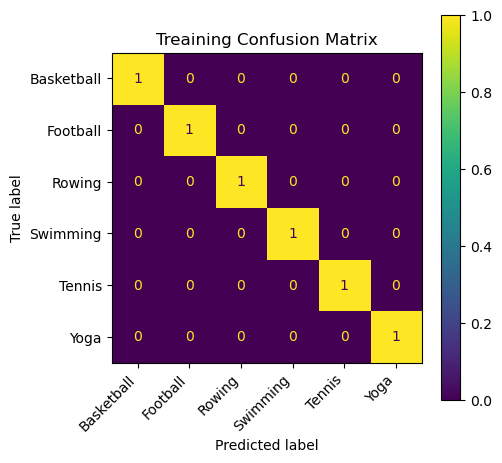

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Treaining Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

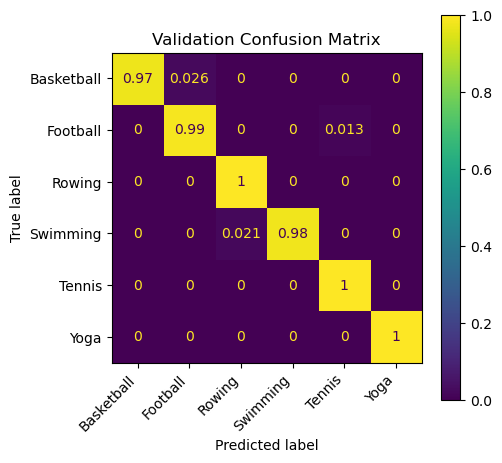

In [83]:
model.load_state_dict(torch.load('best_model_xc.pt'))
model.eval()
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()  

# Testing:

In [84]:
pred_df  = pd.DataFrame(columns=['image_name','label'], index=range(len(test)))
with torch.no_grad():
    for idx, (images, name) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.max(1)[1].cpu().numpy()[0]
        pred_df.iloc[idx,:] =[name[0],predicted] 
        del images, outputs
pred_df.head(5)

,image_name,label
0,0.jpg,4
1,1.jpg,4
2,10.jpg,5
3,100.jpg,5
4,101.jpg,1


In [85]:
pred_df.to_csv("mobilenet_labels_last.csv", index= False)
torch.save(model.state_dict(), f"mobilenet_model_val_score{max(val_acc):.4}.pt")